In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import os
import datetime
from datetime import timedelta, date
import json
import csv
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
def get_channel_files(house_path):
    filepath_array = []
    for x in os.listdir(house_path):
        if 'channel_' in x and x != "channel_1.dat":
            filepath_array.append(house_path+'/'+x)
    return filepath_array

In [3]:
def read_channel_file(filepath):
    df = pd.read_csv(filepath, sep='\\s+', names=['Timestamp','Reading'], parse_dates=['Timestamp'], header=0)
    return df

In [4]:
def resampling(input_df, time):
    dataframe = input_df.set_index('Timestamp')
    dataframe.index = pd.to_datetime(dataframe.index,unit = "s")
    resample = dataframe.resample(time)
    resampled_data = resample.mean()
    final_data = resampled_data.reset_index()
    return final_data

In [5]:
def generate_channel_on_counts(filepath_list, resampling_time, labels_dict, output_files_location):
    results = dict()
    for file in filepath_list:    
        if('button' in file):
            continue
        df = read_channel_file(file)
        resampled_data = resampling(df, resampling_time)
        resampled_data = resampled_data.fillna(0)
        
        x, km = apply_kmeans(resampled_data['Reading'])
        cluster_1, cluster_2, times = get_clusters(x, km, resampled_data.Timestamp)
        
        on_counts_dict = dict()
        for item in times:
            if item != '0':
                temp_date = item.split(" ")[0]
                on_counts_dict[temp_date] = on_counts_dict.setdefault(temp_date, 0)
                on_counts_dict[temp_date] += 1
        channel_id = file.split('/')[-1].split('.')[0]
        appliance = labels_dict[channel_id]
        results[appliance] = on_counts_dict
    return results

In [6]:
def get_labels(labels_file_path):
    labels_df = pd.read_csv(labels_file_path, sep='\\s+', names=['Channel_id','Appliance'])
    labels_df["Channel_id"] = ["channel_"+str(i) for i in range(1,labels_df.shape[0]+1)]
    labels_dict = dict()
    for row in labels_df.iterrows():
        labels_dict[row[1]["Channel_id"]] = row[1]["Appliance"]
    return labels_df, labels_dict

In [7]:
def get_min_max_dates(results):
    min_date = datetime.datetime.max.date()
    max_date = datetime.datetime.min.date()

    for appliance in results.keys():
        dates = list(results[appliance].keys())
        start_date = dates[0]
        end_date = dates[len(dates)-1]
        
        start_date_obj = datetime.datetime.strptime(start_date, "%Y-%m-%d")
        end_date_obj = datetime.datetime.strptime(end_date, "%Y-%m-%d")
        
        if(start_date_obj.date() < min_date):
            min_date = start_date_obj.date()
        
        if(end_date_obj.date() > max_date):
            max_date = end_date_obj.date()

    return min_date, max_date

In [8]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [9]:
def get_dates_list(min_date, max_date):
    Dates = []
    start_dt = min_date
    end_dt = max_date
    for dt in daterange(start_dt, end_dt):
        Dates.append(dt.strftime("%Y-%m-%d"))
    return Dates

In [10]:
def add_missing_dates(results, date_list):
    for appliance in results.keys():
        for date in date_list:
            if date not in list(results[appliance].keys()):
                results[appliance][date] = 0
    return results

In [11]:
def get_average_usage(results):
    appliance_usage_dict = dict()
    for appliance in results.keys():
        sum_of_hours = 0
        average_usage = 0
        for date in results[appliance].keys():
            sum_of_hours += results[appliance][date]
        average_usage = (sum_of_hours)/(len(list(results[appliance]))*2)
        appliance_usage_dict[appliance] = average_usage
    return appliance_usage_dict

In [12]:
def get_percent_usage(results):
    appliance_usage_dict = dict()
    for appliance in results.keys():
        sum_of_hours = 0
        percent_usage = 0
        for date in results[appliance].keys():
            sum_of_hours += results[appliance][date]
        percent_usage = (sum_of_hours * 100)/(len(list(results[appliance])) * 48)
        appliance_usage_dict[appliance] = percent_usage
    return appliance_usage_dict

In [13]:
def plot_appliance(appliance, xlabel, ylabel, appliance_usage_df):
    fig, ax = plt.subplots(figsize=(20,8))

    ax.plot(appliance_usage_df[xlabel], appliance_usage_df[ylabel]/2)
    
    ax.set(xlabel = xlabel, ylabel = ylabel)
    
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'axes.titlesize': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    
#     SMALL_SIZE = 8
#     MEDIUM_SIZE = 10
#     BIGGER_SIZE = 12

#     plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#     plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#     plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # use a more precise date string for the x axis locations in the
    # toolbar
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.set_title("Usage of " + appliance +" over time")

In [14]:
def plot_appliance_usage(appliance, appliance_dict):
    appliance_usage_df = pd.DataFrame({"Dates" : pd.to_datetime(list(appliance_dict[appliance].keys())), "Hours" : list(appliance_dict[appliance].values())})
    appliance_usage_df.sort_values(by=['Dates'], inplace = True)
    plot_appliance(appliance, "Dates", "Hours", appliance_usage_df)    

In [15]:
def plot_bar_graph(xlabel, ylabel, df):
    fig= plt.figure(figsize=(20,8))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation='vertical')
    plt.bar(df[xlabel], df[ylabel]) 

In [16]:
def apply_kmeans(column):
    x = np.array(column)
    km = KMeans(n_clusters=2, random_state = 10)
    res = km.fit(x.reshape(-1,1))
    return x, km

In [17]:
def get_clusters(x, km, timeindex):
    times_1 = []
    times_2 = []
    cluster_1 = []
    cluster_2 = []
    for i in range(len(km.labels_)):
        if(km.labels_[i] == 0):
            cluster_1.append(x[i])
            times_1.append('0')
            times_2.append(str(timeindex[i]))
        else:
            cluster_2.append(x[i])
            times_1.append(str(timeindex[i]))
            times_2.append('0')
            
    if cluster_1[0] < cluster_2[0]:
        return cluster_1, cluster_2, times_1
    if cluster_1[0] > cluster_2[0]:
        return cluster_2, cluster_1, times_2

## Get resampled channel data

In [18]:
path_to_ukdale_dataset = "../../../../../Dataset/ukdale/House_2/"
filepath_list = get_channel_files(path_to_ukdale_dataset)
path_to_resampled_channel_on_count_data = "./Channel_On_Count_data/House_2/"

In [19]:
# path_to_ukdale_dataset = "../../../Disaggregation/House_2/"
# filepath_list = get_channel_files(path_to_ukdale_dataset)
# path_to_resampled_channel_on_count_data = "./Disaggregation/Channel_On_Count_data/House_2/"

## Get labels from label file

In [20]:
labels_df, labels_dict = get_labels(path_to_ukdale_dataset + "labels.dat")

In [21]:
labels_df

,Channel_id,Appliance
0,channel_1,aggregate
1,channel_2,laptop
2,channel_3,monitor
3,channel_4,speakers
4,channel_5,server
5,channel_6,router
6,channel_7,server_hdd
7,channel_8,kettle
8,channel_9,rice_cooker
9,channel_10,running_machine


## Generate a dictionary with appliances as keys and their usage data for each day as value

In [22]:
all_appliance_on_count_dict = generate_channel_on_counts(filepath_list, "30min", labels_dict, path_to_resampled_channel_on_count_data)

In [23]:
# all_appliance_on_count_dict

## Find min and max dates

In [24]:
min_date, max_date = get_min_max_dates(all_appliance_on_count_dict)

In [25]:
print(min_date)
print(max_date)

2013-02-17
2013-10-10


## Insert missing dates between min and max dates in appliance on count dictionary

In [26]:
date_list = get_dates_list(min_date, max_date)
all_appliance_on_count_dict = add_missing_dates(all_appliance_on_count_dict, date_list)

## Get average number of hour usage of each appliance each day

In [27]:
appliance_average_usage_dict = get_average_usage(all_appliance_on_count_dict)

## Get % usage of each appliance over the period between min and max date

In [28]:
appliance_usage_dict = get_percent_usage(all_appliance_on_count_dict)

In [29]:
# all_appliance_on_count_dict

## Plot all appliance average number of hours used

In [30]:
appliance_average_usage_df = pd.DataFrame({"Appliances" : list(appliance_average_usage_dict.keys()), "Average hours used" : list(appliance_average_usage_dict.values())})

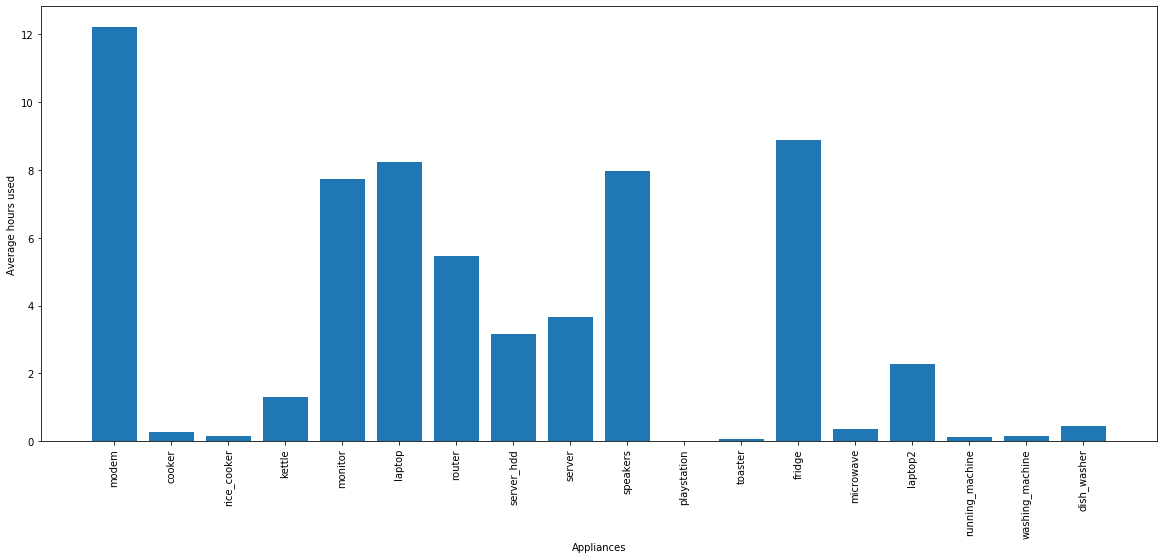

In [31]:
plot_bar_graph("Appliances", "Average hours used", appliance_average_usage_df)

In [32]:
# plot_bar_graph("Appliances", "Average hours used", appliance_average_usage_df)

## Plot all appliance % usage 

In [33]:
appliance_usage_df = pd.DataFrame({"Appliances" : list(appliance_usage_dict.keys()), "% Usage" : list(appliance_usage_dict.values())})


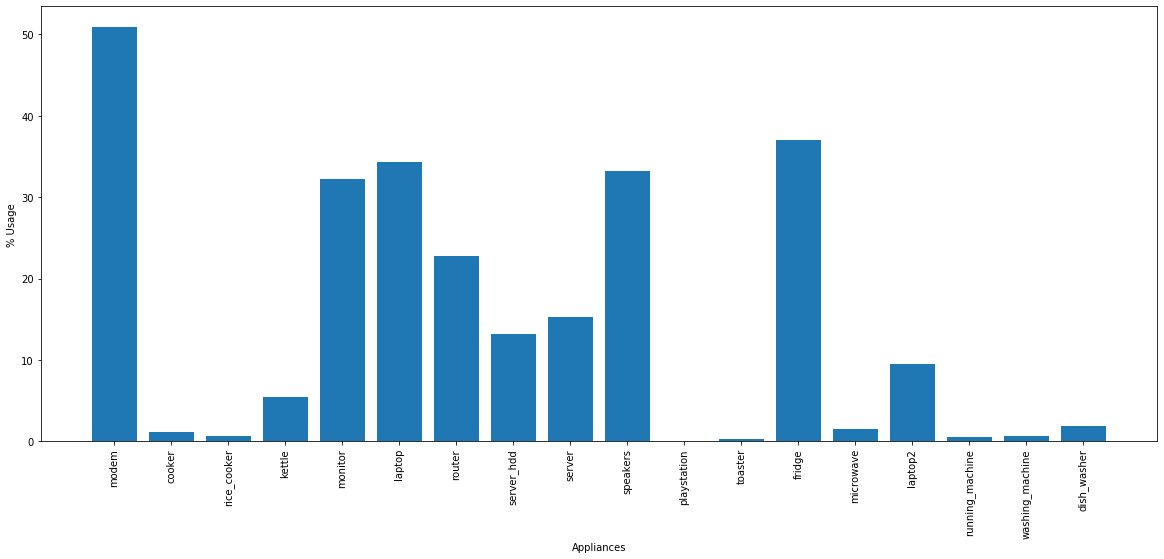

In [34]:
plot_bar_graph("Appliances", "% Usage", appliance_usage_df)

## Plot individual appliance usage pattern over the period of min to max date

In [35]:
plot_appliance_usage("electric_heater", all_appliance_on_count_dict)

KeyError: 'electric_heater'

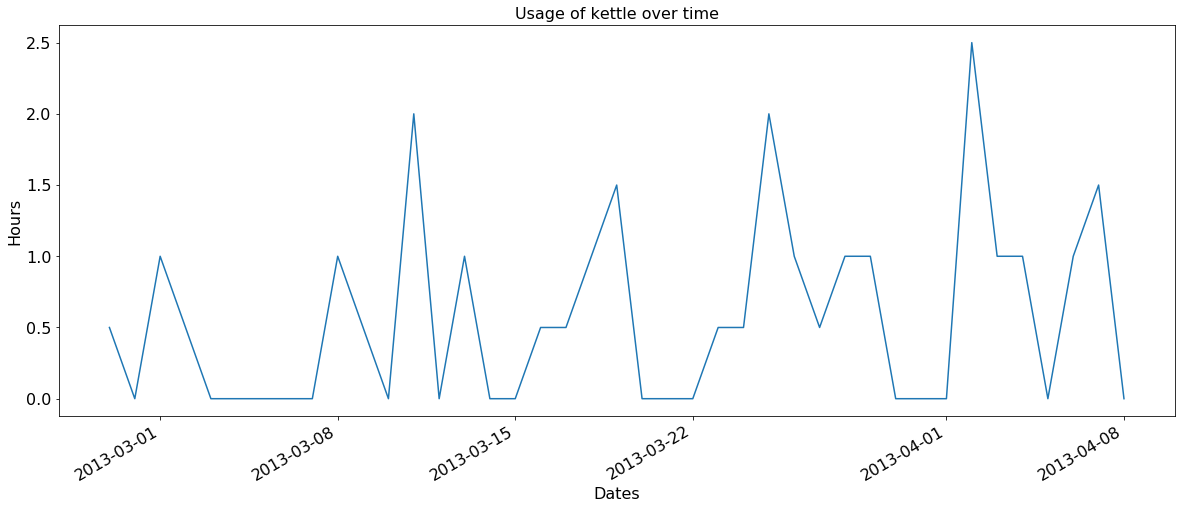

In [46]:
plot_appliance_usage("kettle", all_appliance_on_count_dict)

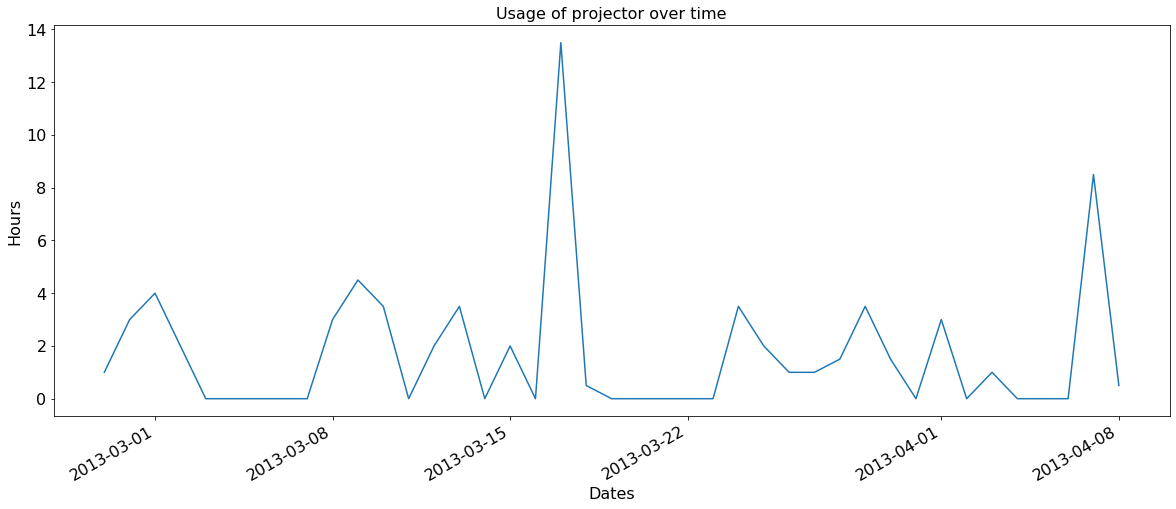

In [45]:
plot_appliance_usage("projector", all_appliance_on_count_dict)

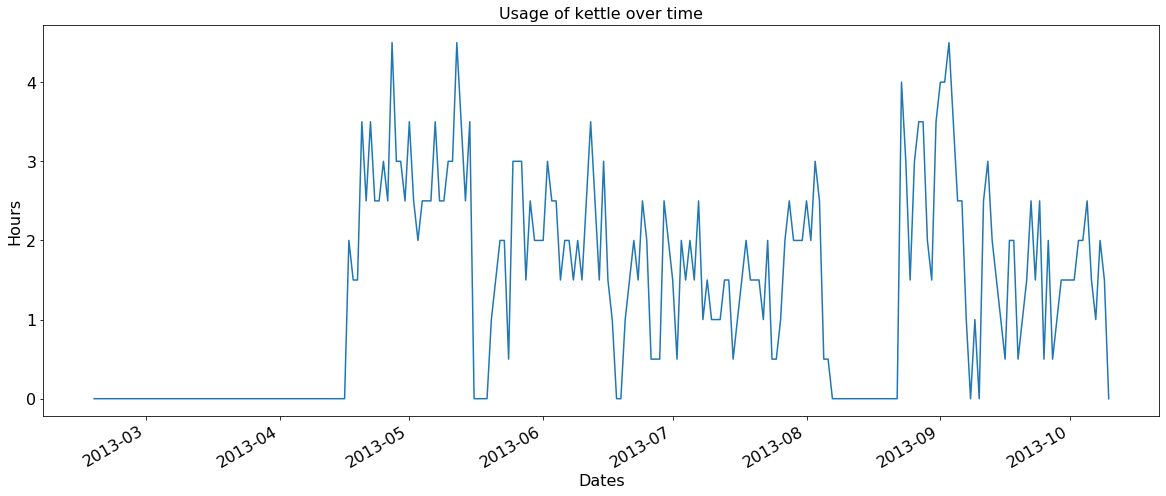

In [153]:
# plot_appliance_usage("kettle", all_appliance_on_count_dict)

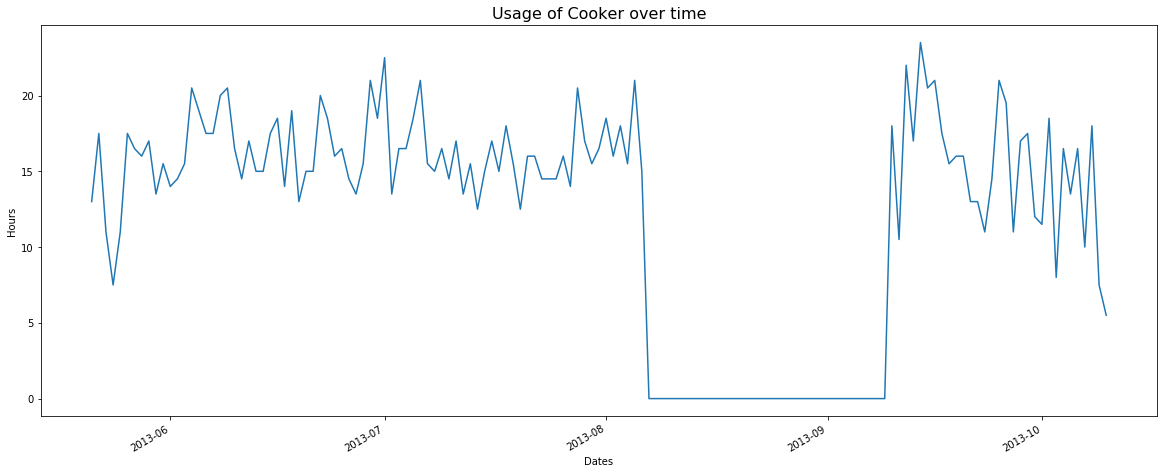

In [27]:
plot_appliance_usage("Cooker", all_appliance_on_count_dict)

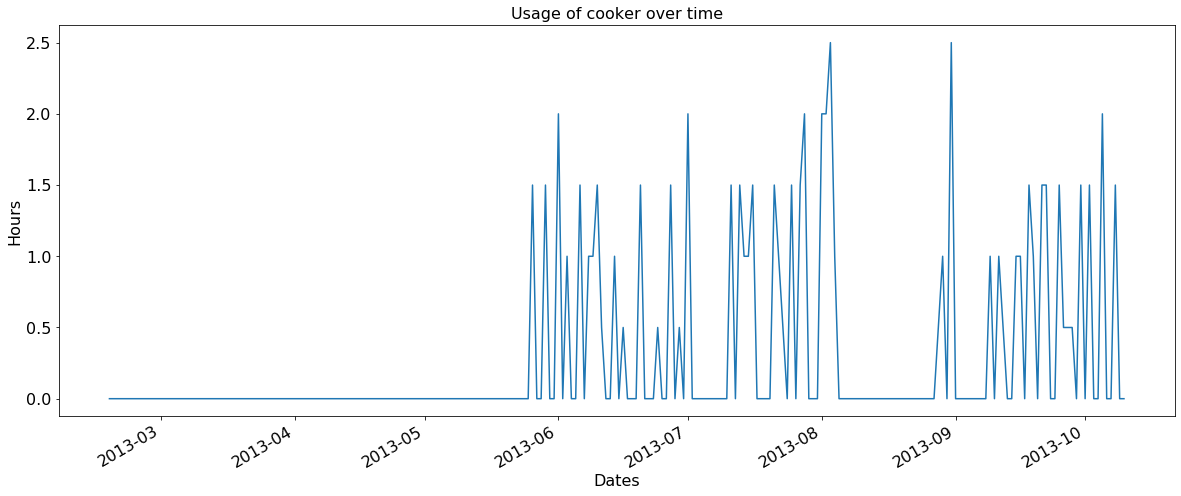

In [154]:
plot_appliance_usage("cooker", all_appliance_on_count_dict)

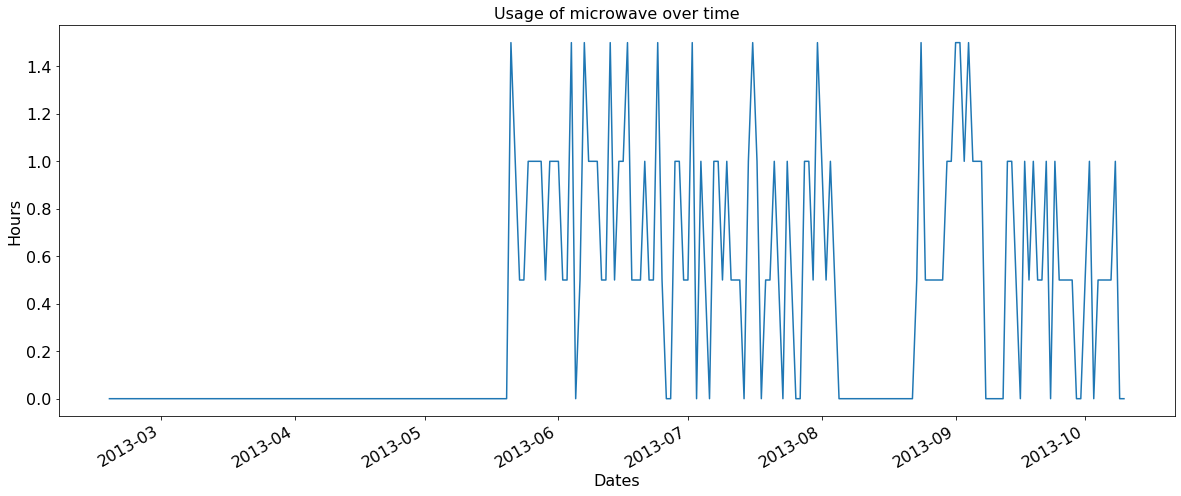

In [155]:
plot_appliance_usage("microwave", all_appliance_on_count_dict)

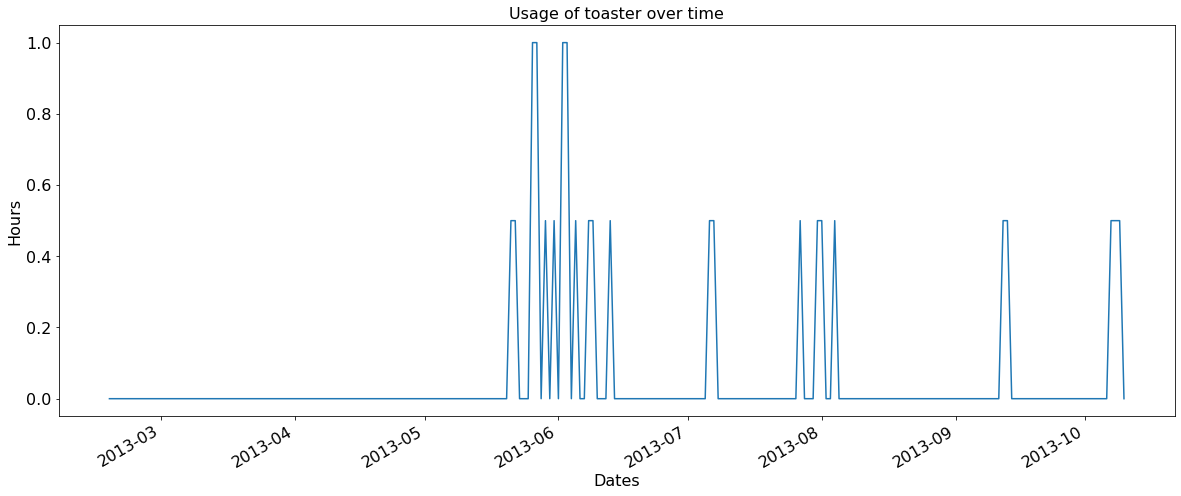

In [156]:
plot_appliance_usage("toaster", all_appliance_on_count_dict)

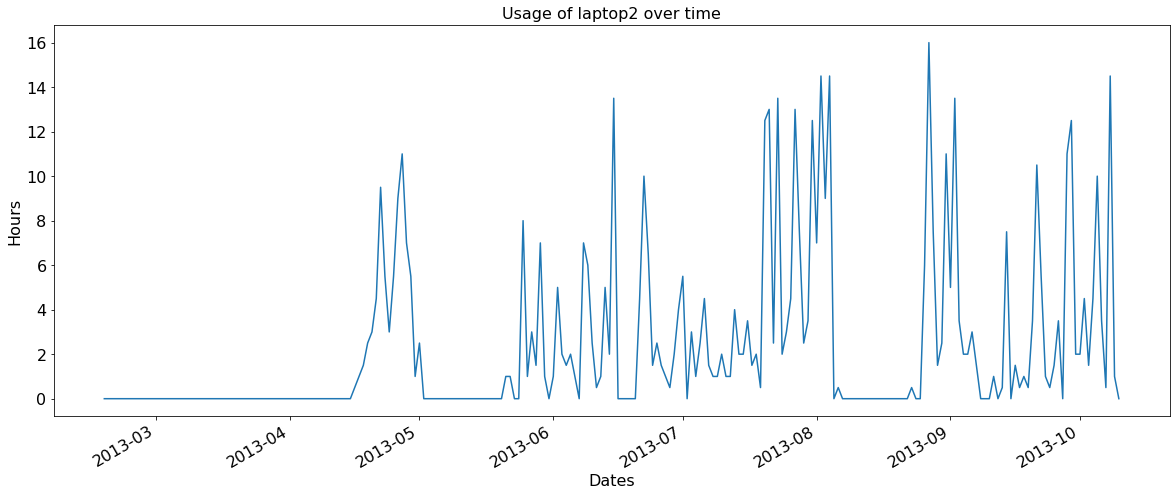

In [157]:
plot_appliance_usage("laptop2", all_appliance_on_count_dict)

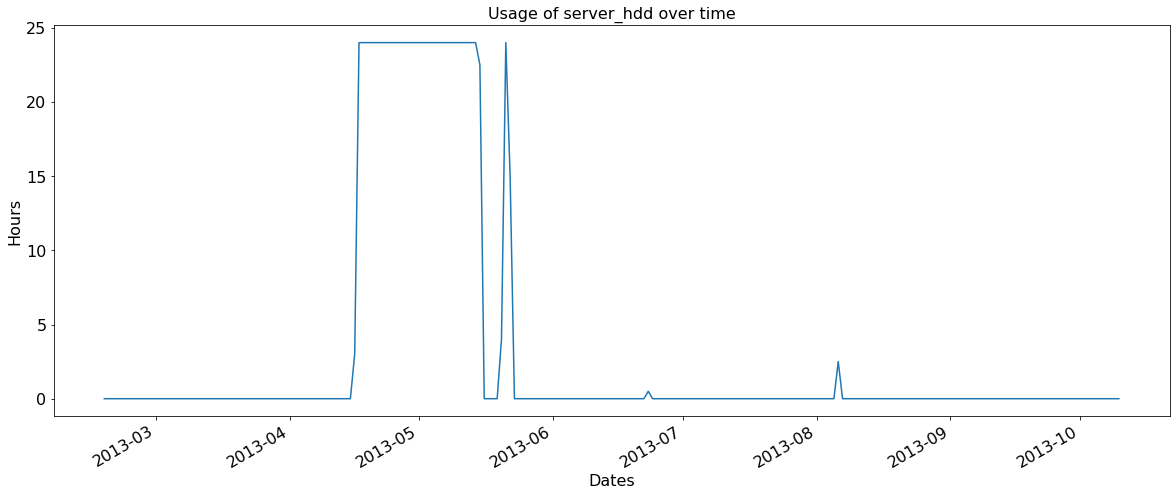

In [158]:
plot_appliance_usage("server_hdd", all_appliance_on_count_dict)

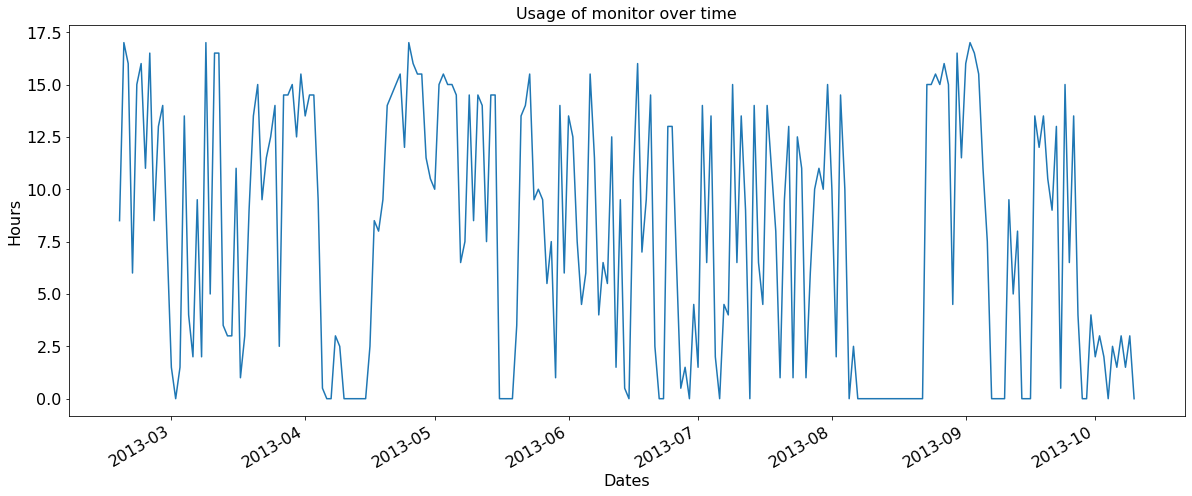

In [159]:
plot_appliance_usage("monitor", all_appliance_on_count_dict)

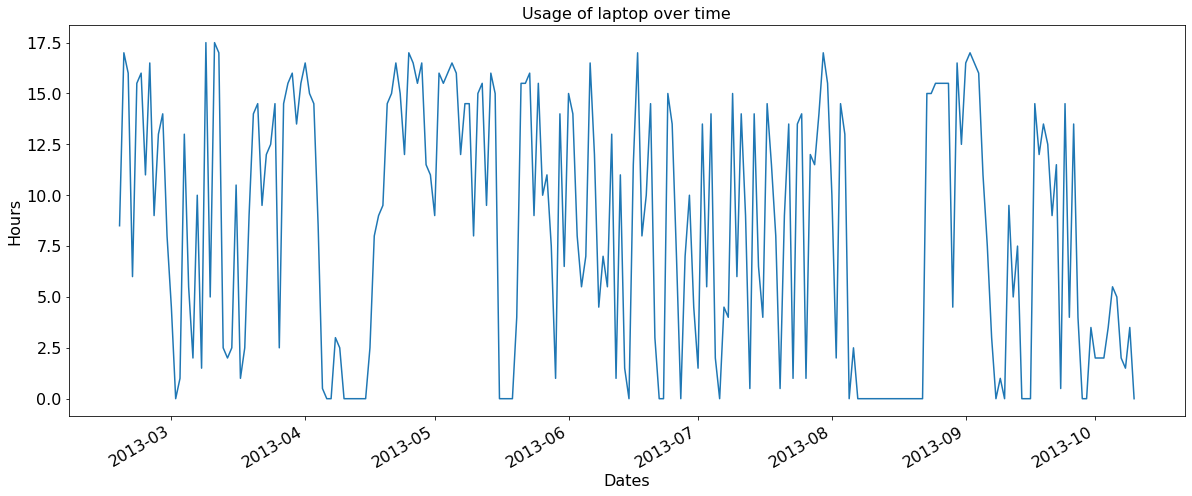

In [160]:
plot_appliance_usage("laptop", all_appliance_on_count_dict)

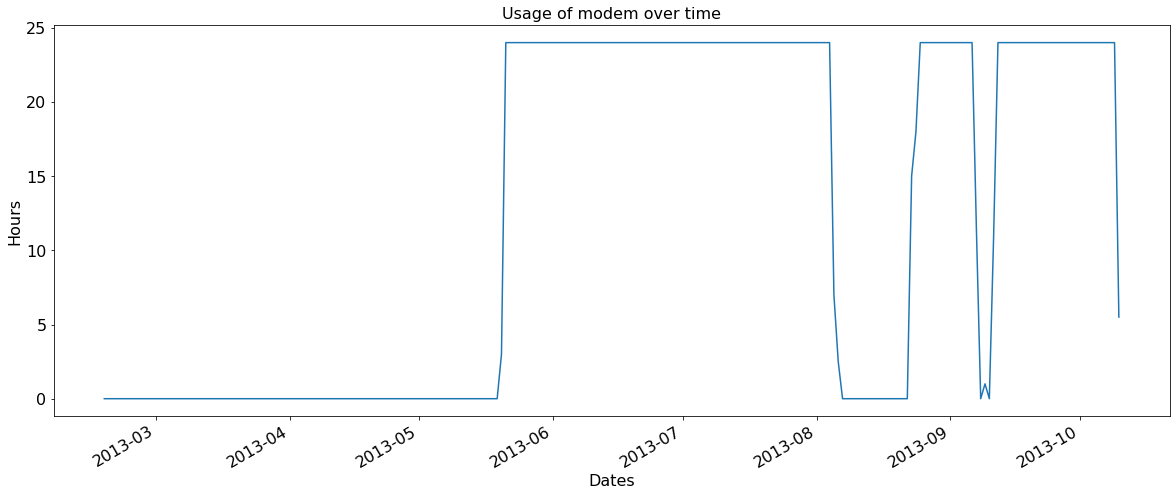

In [161]:
plot_appliance_usage("modem", all_appliance_on_count_dict)

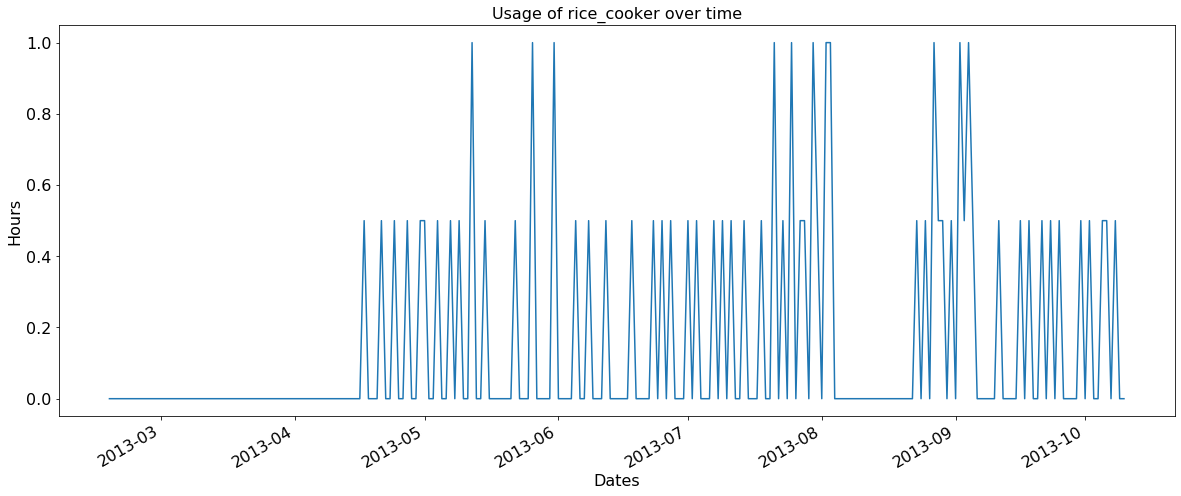

In [162]:
plot_appliance_usage("rice_cooker", all_appliance_on_count_dict)

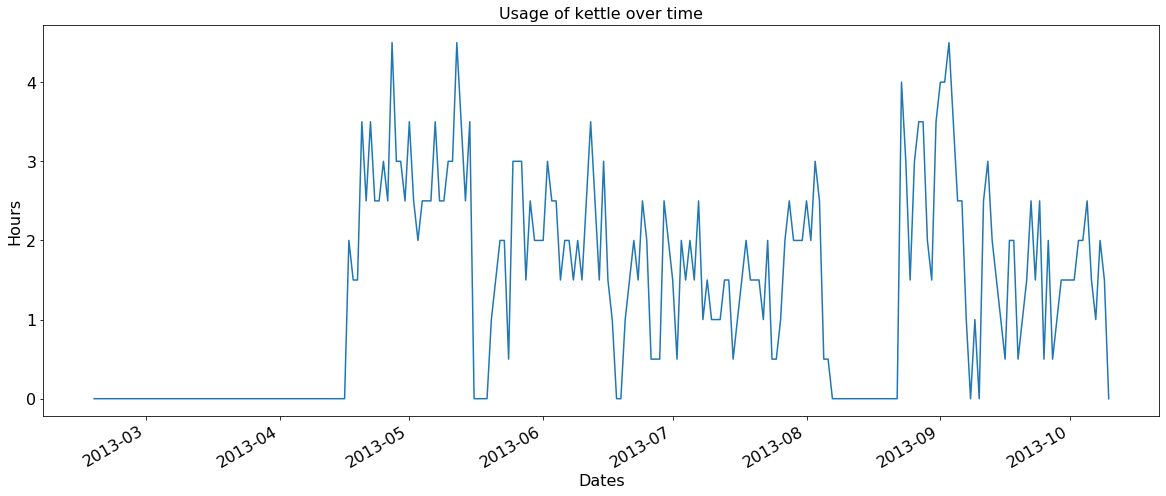

In [163]:
plot_appliance_usage("kettle", all_appliance_on_count_dict)

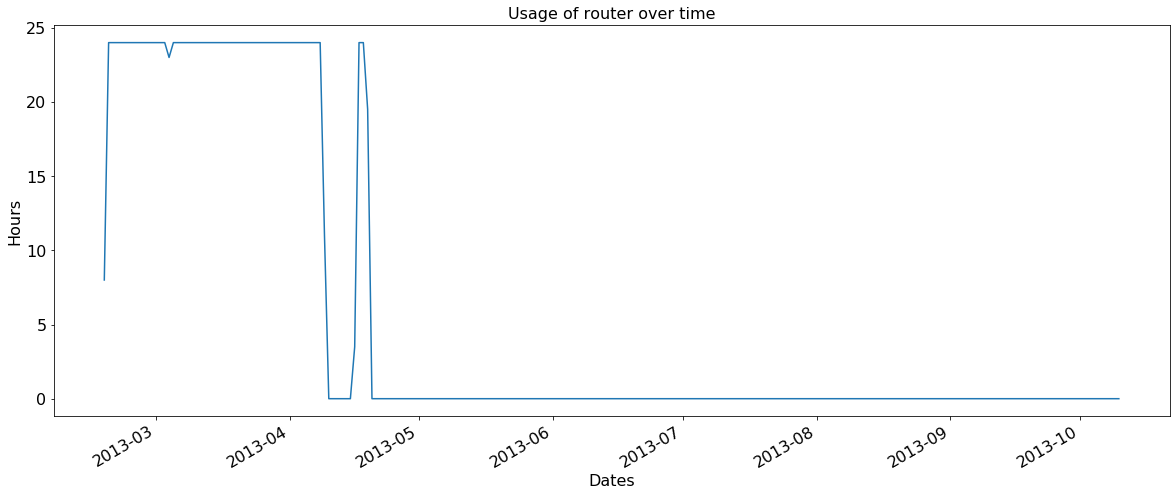

In [164]:
plot_appliance_usage("router", all_appliance_on_count_dict)

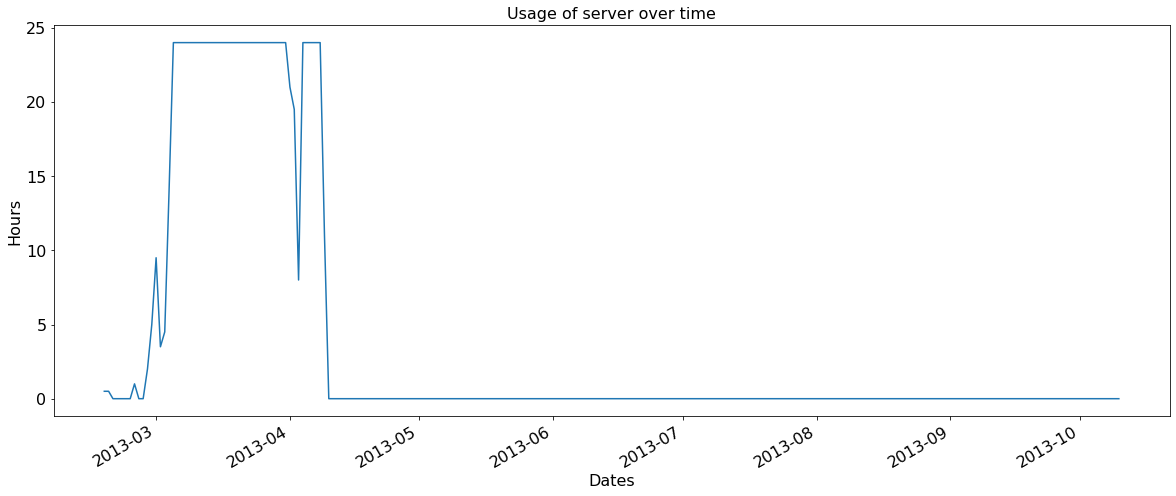

In [165]:
plot_appliance_usage("server", all_appliance_on_count_dict)

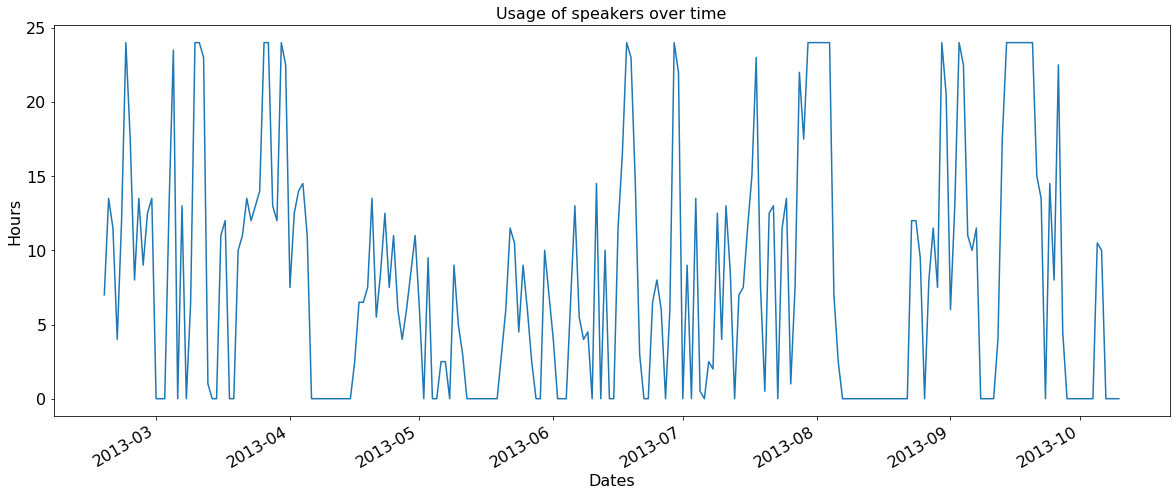

In [166]:
plot_appliance_usage("speakers", all_appliance_on_count_dict)

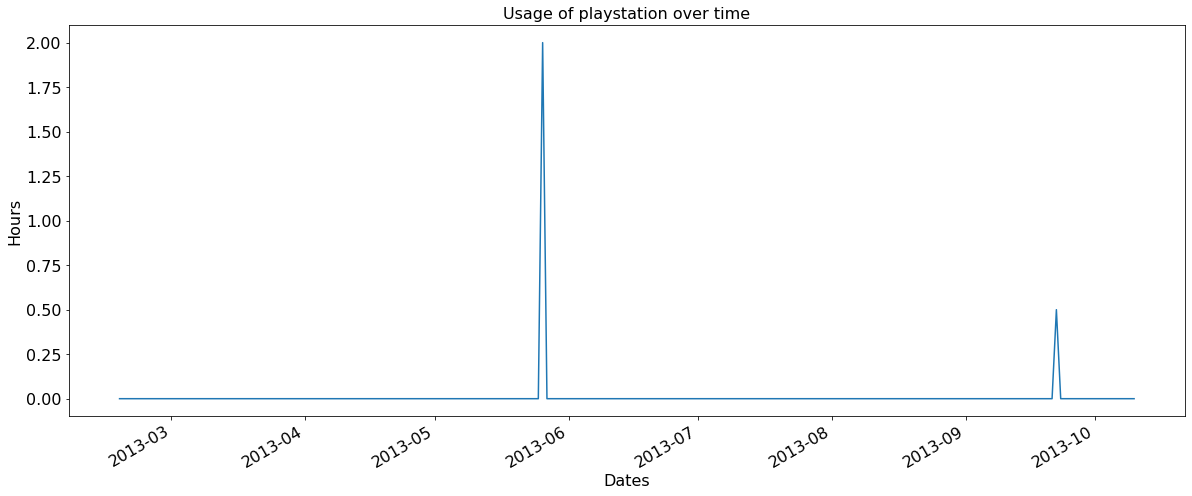

In [167]:
plot_appliance_usage("playstation", all_appliance_on_count_dict)

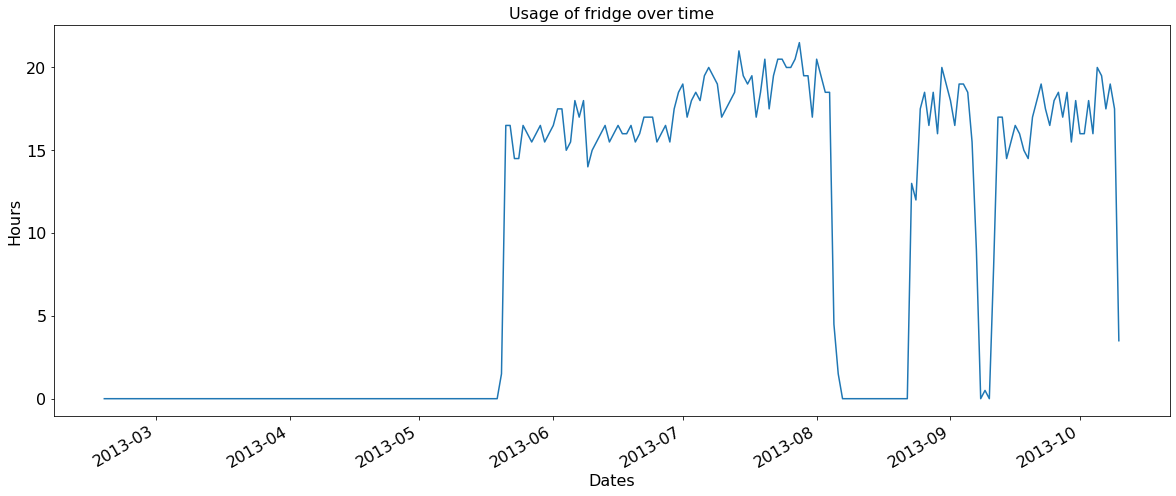

In [168]:
plot_appliance_usage("fridge", all_appliance_on_count_dict)

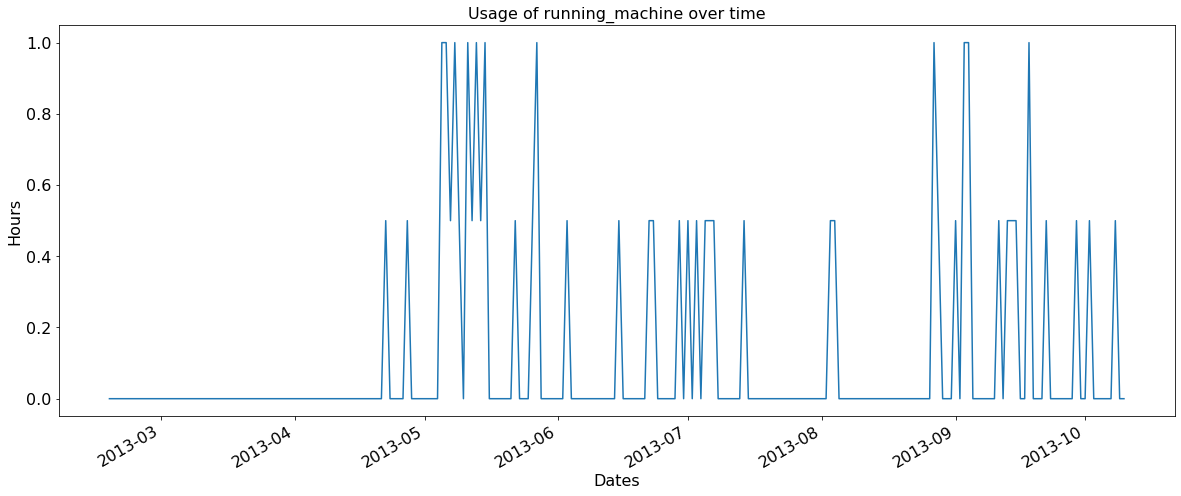

In [169]:
plot_appliance_usage("running_machine", all_appliance_on_count_dict)

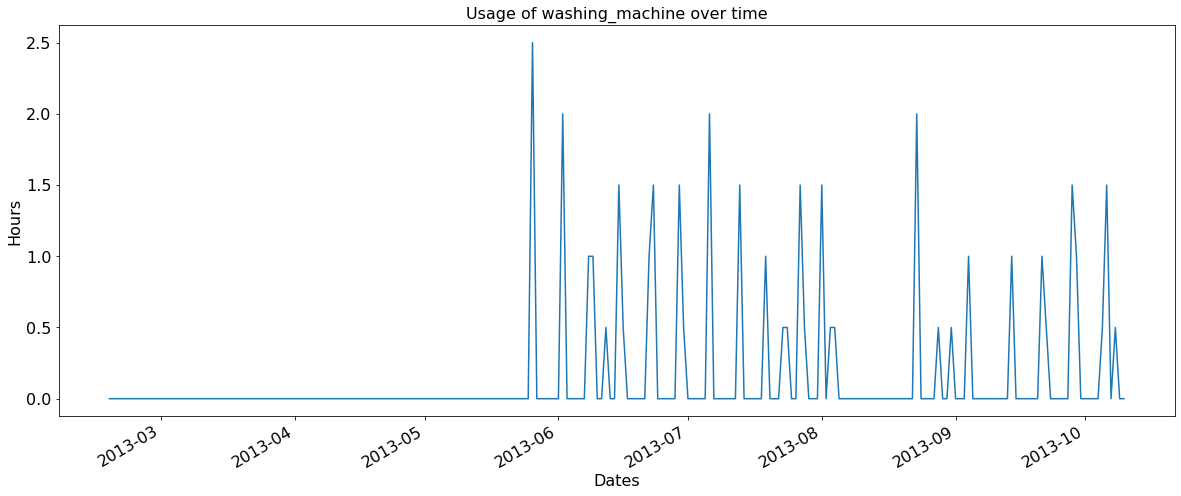

In [170]:
plot_appliance_usage("washing_machine", all_appliance_on_count_dict)

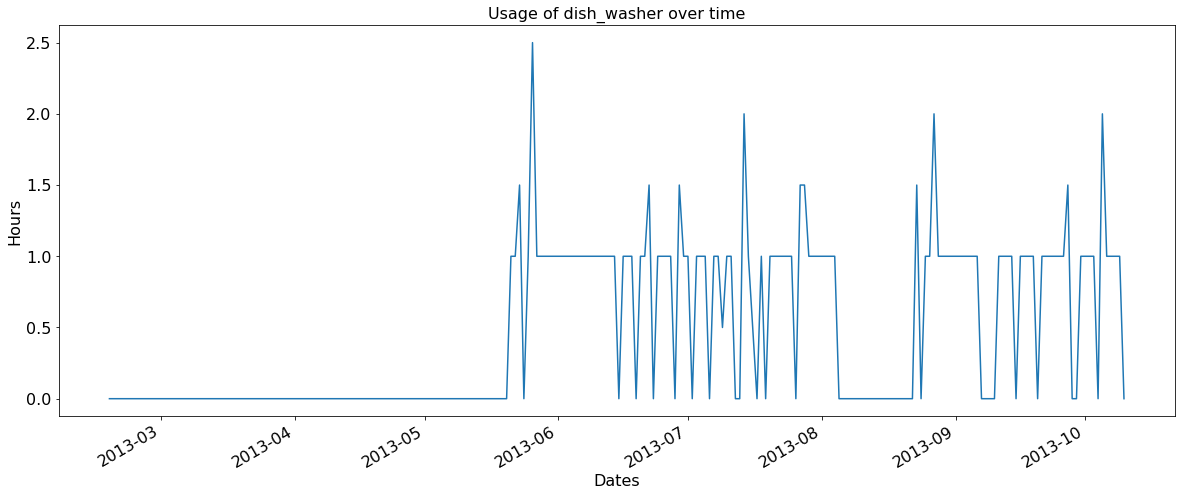

In [171]:
plot_appliance_usage("dish_washer", all_appliance_on_count_dict)

In [79]:
filepath_list = [path for path in filepath_list if 'button' not in path]

In [82]:
filepath_list

['../../../../../Dataset/ukdale/house_2/channel_18.dat',
 '../../../../../Dataset/ukdale/house_2/channel_19.dat',
 '../../../../../Dataset/ukdale/house_2/channel_9.dat',
 '../../../../../Dataset/ukdale/house_2/channel_8.dat',
 '../../../../../Dataset/ukdale/house_2/channel_3.dat',
 '../../../../../Dataset/ukdale/house_2/channel_2.dat',
 '../../../../../Dataset/ukdale/house_2/channel_6.dat',
 '../../../../../Dataset/ukdale/house_2/channel_7.dat',
 '../../../../../Dataset/ukdale/house_2/channel_5.dat',
 '../../../../../Dataset/ukdale/house_2/channel_4.dat',
 '../../../../../Dataset/ukdale/house_2/channel_17.dat',
 '../../../../../Dataset/ukdale/house_2/channel_16.dat',
 '../../../../../Dataset/ukdale/house_2/channel_14.dat',
 '../../../../../Dataset/ukdale/house_2/channel_15.dat',
 '../../../../../Dataset/ukdale/house_2/channel_11.dat',
 '../../../../../Dataset/ukdale/house_2/channel_10.dat',
 '../../../../../Dataset/ukdale/house_2/channel_12.dat',
 '../../../../../Dataset/ukdale/house_2

In [101]:
filepath_list[2]

'../../../../../Dataset/ukdale/house_2/channel_9.dat'

In [125]:
cluster_1_dict = dict()
cluster_2_dict = dict()
times_dict = dict()

for file in filepath_list:
    df = read_channel_file(file)
    resampled_data = resampling(df, "30min")
    resampled_data = resampled_data.fillna(0)

    x, km = apply_kmeans(resampled_data['Reading'])
    cluster_1, cluster_2, times = get_clusters(x, km, resampled_data.Timestamp)
    
    channel = file.split('/')[-1][:-4]
    
    print(channel)
    cluster_1_dict[channel] = cluster_1
    cluster_2_dict[channel] = cluster_2
    times_dict[channel] = times

channel_18
channel_19
channel_9
channel_8
channel_3
channel_2
channel_6
channel_7
channel_5
channel_4
channel_17
channel_16
channel_14
channel_15
channel_11
channel_10
channel_12
channel_13


In [143]:
cluster_1_dict['channel_5'][:10]

[21.475728155339805,
 22.42808219178082,
 22.42611683848797,
 22.371134020618555,
 21.91780821917808,
 21.567010309278352,
 21.713804713804713,
 21.64527027027027,
 20.78767123287671,
 22.244827586206895]

In [ ]:
## 6th try

In [172]:
for channel in times_dict.keys():
    if cluster_1_dict[channel][0] > cluster_2_dict[channel][0]:
        print(channel)

In [ ]:
## 5th try

In [121]:
for channel in times_dict.keys():
    if cluster_1_dict[channel][0] > cluster_2_dict[channel][0]:
        print(channel)

channel_18
channel_6
channel_7
channel_4
channel_14


In [ ]:
## 4th try

In [119]:
for channel in times_dict.keys():
    if cluster_1_dict[channel][0] > cluster_2_dict[channel][0]:
        print(channel)

channel_18
channel_6
channel_7
channel_4
channel_14


In [ ]:
## 3rd try

In [116]:
for channel in times_dict.keys():
    if cluster_1_dict[channel][0] > cluster_2_dict[channel][0]:
        print(channel)

channel_18
channel_5
channel_4
channel_17
channel_14


In [ ]:
## 2nd try

In [111]:
for channel in times_dict.keys():
    if cluster_1_dict[channel][0] > cluster_2_dict[channel][0]:
        print(channel)

channel_18
channel_8
channel_2
channel_7
channel_5


In [113]:
cluster_1_dict['channel_4'][:10]

[3.178694158075601,
 3.0103092783505154,
 2.9965635738831615,
 2.9965635738831615,
 2.9896907216494846,
 3.0103092783505154,
 3.0,
 3.0103092783505154,
 3.0,
 3.0]

In [114]:
cluster_2_dict['channel_4'][:10]

[9.466019417475728,
 10.593984962406015,
 10.445205479452055,
 10.288659793814434,
 10.323024054982818,
 10.479452054794521,
 10.154639175257731,
 10.346801346801346,
 10.307432432432432,
 10.493150684931507]

In [176]:
for channel in times_dict.keys():
    print(channel)
    print("Cluster 1")
    print(cluster_1_dict[channel][:10])
    print("Cluster 2")
    print(cluster_2_dict[channel][:10])
    print()
    print(times_dict[channel][:10])
    print()

channel_18
Cluster 1
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cluster 2
[9.0, 9.006849315068493, 9.01027397260274, 9.017123287671232, 9.01023890784983, 9.013698630136986, 9.01027397260274, 9.034129692832764, 9.006825938566553, 9.006849315068493]

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

channel_19
Cluster 1
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6]
Cluster 2
[7.236111111111111, 9.102739726027398, 9.067796610169491, 8.68041237113402, 9.238907849829351, 5.510273972602739, 8.681506849315069, 9.39041095890411, 9.212328767123287, 9.571917808219178]

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

channel_9
Cluster 1
[0.956140350877193, 0.9794520547945206, 0.9965753424657534, 0.9965635738831615, 0.9965753424657534, 0.9965635738831615, 0.9863481228668942, 0.9794520547945206, 1.0, 0.9897610921501706]
Cluster 2
[217.8976109215017, 287.21724137931034, 236.92150170648463, 197.01027397260273, 308.7952218430034, 219.57191780821918, 261.80479452054794, 245.664383561